In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 17, 'figure.figsize': [15, 7]})

## Net electricity consumption w/o storage prediction from memory for the 5-buildings district

Here we repeat the original 'net_consumption_dot_product' notebook, but for the whole district together.

In [36]:
net_consumption_df = pd.read_csv("data/buildings_net_electricity_consumption_without_storage.csv")
net_consumption_district = np.array(net_consumption_df.sum(axis=1))
net_consumption_district = np.append(np.zeros(23), net_consumption_district)
net_consumption_district = np.append(net_consumption_district, np.zeros(24))

norm_district_24 = np.array([np.sqrt(np.sum(net_consumption_district[i:i+24]**2)) for i in range(len(net_consumption_district)-47)])

linear_weights = np.arange(1, 5) / 4
norm_district_4 = np.array([np.sqrt(np.sum((net_consumption_district[i:i+4] ** 2) * linear_weights)) for i in range(20, len(net_consumption_district)-27)])

np.save('data/net_consumption_district.npy', net_consumption_district)
np.save('data/net_consumption_norm_district24.npy', norm_district_24)
np.save('data/net_consumption_norm_district4.npy', norm_district_4)

In [37]:
def predict_next_24h_district_masked(input_vec: np.ndarray, ratio: float) -> np.ndarray:
    """
    Predict the next day consumption from the previous 24 hours
    Args:
        input_vec (np.array): the vector of the net consumption, len=24
        ratio (float): the ratio of the input vector to be masked
    """

    assert len(input_vec) == 24, "The input vector must be of length 24"

    input_vec = input_vec / np.sqrt(sum(input_vec ** 2))

    net_consumption = np.load('data/net_consumption_district.npy')
    norm_vec = np.load('data/net_consumption_norm_district24.npy')

    mask_length = int(len(net_consumption) * ratio)
    net_consumption = net_consumption[:-mask_length]
    norm_vec = norm_vec[:-mask_length]

    correlation = np.array([np.sum(input_vec * net_consumption[i:i+24]) for i in range(len(net_consumption)-47)])
    correlation /= norm_vec

    idx_from_correlation = np.argmax(correlation)
    prediction = net_consumption[idx_from_correlation+24:idx_from_correlation+48]

    return prediction

In [40]:
def predict_next_4h_district_masked(input_vec: np.ndarray, ratio: float) -> np.ndarray:
    """
    Predict the next 4 hours consumption from the previous 4 hours
    Args:
        input_vec (np.array): the vector of the net consumption, len=24
        ratio (float): the ratio of the input vector to be masked
    """

    assert len(input_vec) == 4, "The input vector must be of length 4"

    weights = np.array([0.25, 0.5, 0.75, 1])
    input_vec = input_vec / np.sqrt(sum((input_vec ** 2) * weights))

    net_consumption = np.load('data/net_consumption_district.npy')
    net_consumption = net_consumption[20:-20]
    norm_vec = np.load('data/net_consumption_norm_district4.npy')

    mask_length = int(len(net_consumption) * ratio)
    net_consumption = net_consumption[:-mask_length]
    norm_vec = norm_vec[:-mask_length]

    correlation = np.array([np.sum(input_vec * net_consumption[i:i+4] * weights) for i in range(len(net_consumption)-7)])
    correlation /= norm_vec

    idx_from_correlation = np.argmax(correlation)
    prediction = net_consumption[idx_from_correlation+4:idx_from_correlation+8]

    return prediction

In [44]:
def predict_next_day_district_masked(input_vec: np.ndarray, ratio: float) -> np.ndarray:
    """
    Predict the next 4 hours consumption from the previous 4 hours
    Args:
        input_vec (np.array): the vector of the net consumption, len=24
        ratio (float): the ratio of the input vector to be masked
    """

    weights = np.append(np.array([0, 0.25, 0.5, 0.75]), np.ones(20))

    prediction_24 = predict_next_24h_district_masked(input_vec, ratio)
    prediction_4 = np.append(predict_next_4h_district_masked(input_vec[-4:], ratio), np.zeros(20))

    return prediction_24 * weights + prediction_4 * (1 - weights)


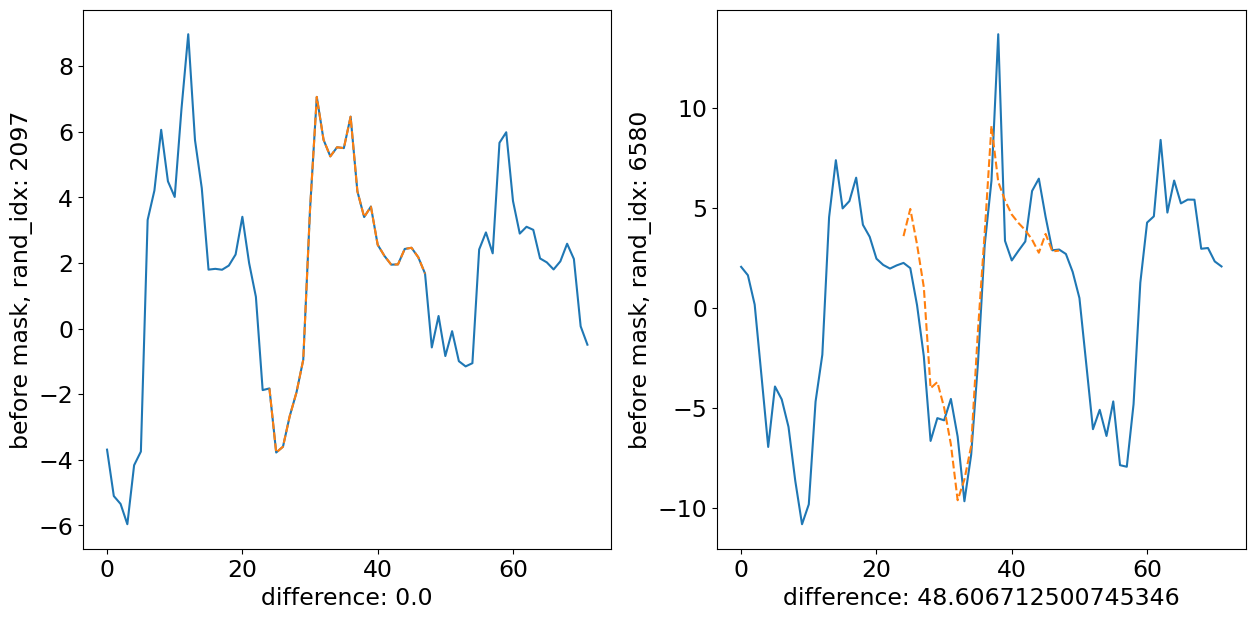

In [45]:
masking_ratio = 0.3
mask_len = int(len(net_consumption_district) * masking_ratio)

fig, (ax1, ax2) = plt.subplots(1, 2)
rand_idx1 = np.random.randint(0, len(net_consumption_district) - 48 - mask_len)
predicted = predict_next_day_district_masked(net_consumption_district[rand_idx1:rand_idx1 + 24], masking_ratio)
ax1.plot(net_consumption_district[rand_idx1:rand_idx1 + 72], label="Input")
ax1.plot(np.arange(24, 48), predicted, label="Prediction", linestyle="--")
ax1.set_ylabel(f"before mask, rand_idx: {rand_idx1}")
ax1.set_xlabel(f"difference: {sum(abs(predicted - net_consumption_district[rand_idx1+24:rand_idx1+48]))}")

rand_idx2 = np.random.randint(len(net_consumption_district) - mask_len + 24, len(net_consumption_district) - 48)
predicted = predict_next_day_district_masked(net_consumption_district[rand_idx2:rand_idx2 + 24], masking_ratio)
ax2.plot(net_consumption_district[rand_idx2:rand_idx2 + 72], label="Input")
ax2.plot(np.arange(24, 48), predicted, label="Prediction", linestyle="--")
ax2.set_ylabel(f"before mask, rand_idx: {rand_idx2}")
ax2.set_xlabel(f"difference: {sum(abs(predicted - net_consumption_district[rand_idx2+24:rand_idx2+48]))}")

plt.show()

## Prediction certainty
We can keep to the 24hrs only and extract the certainty of the prediction from the correlation between the input and the best fitted sequence.
For this, we will use an additional function:

In [46]:
def predict_next_24h_district_masked_with_certainty(input_vec: np.ndarray, ratio: float) -> (np.ndarray, float):
    """
    Predict the next day consumption from the previous 24 hours
    Args:
        input_vec (np.array): the vector of the net consumption, len=24
        ratio (float): the ratio of the input vector to be masked
    """

    assert len(input_vec) == 24, "The input vector must be of length 24"

    input_vec = input_vec / np.sqrt(sum(input_vec ** 2))

    net_consumption = np.load('data/net_consumption_district.npy')
    norm_vec = np.load('data/net_consumption_norm_district24.npy')

    mask_length = int(len(net_consumption) * ratio)
    net_consumption = net_consumption[:-mask_length]
    norm_vec = norm_vec[:-mask_length]

    correlation = np.array([np.sum(input_vec * net_consumption[i:i+24]) for i in range(len(net_consumption)-47)])
    correlation /= norm_vec

    idx_from_correlation = np.argmax(correlation)
    prediction = net_consumption[idx_from_correlation+24:idx_from_correlation+48]

    return prediction, correlation[idx_from_correlation]

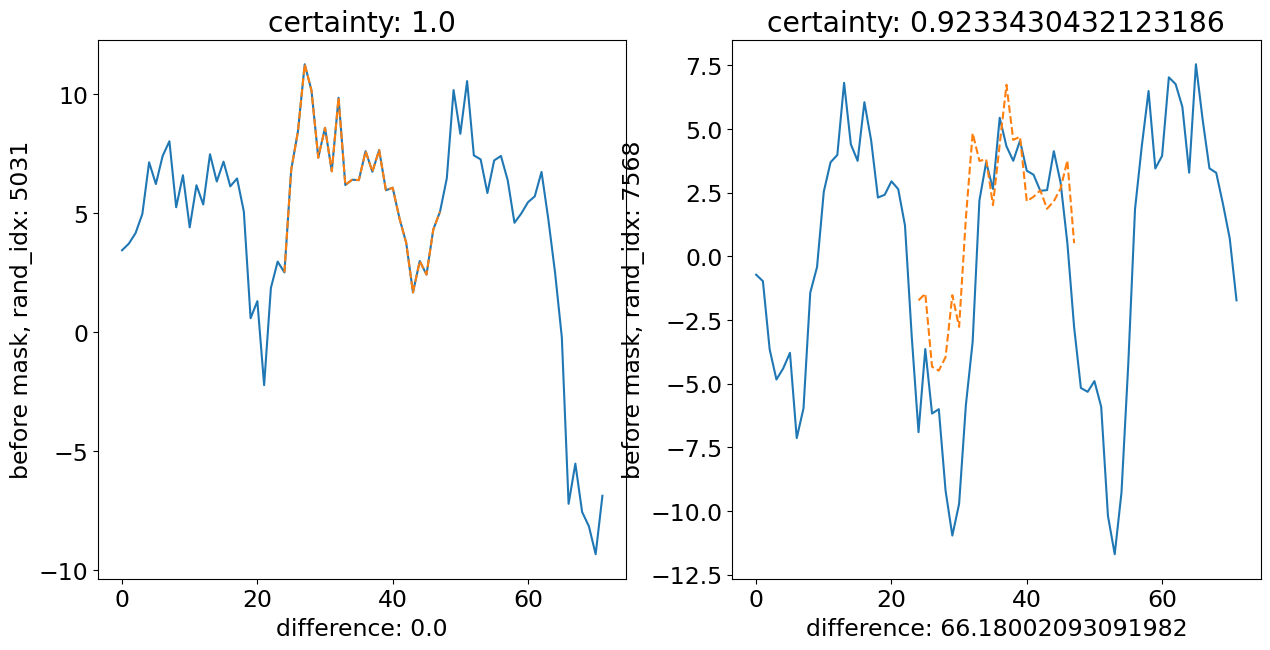

In [47]:
masking_ratio = 0.3
mask_len = int(len(net_consumption_district) * masking_ratio)

fig, (ax1, ax2) = plt.subplots(1, 2)
rand_idx1 = np.random.randint(0, len(net_consumption_district) - 48 - mask_len)
predicted, certainty = predict_next_24h_district_masked_with_certainty(net_consumption_district[rand_idx1:rand_idx1 + 24], masking_ratio)
ax1.plot(net_consumption_district[rand_idx1:rand_idx1 + 72], label="Input")
ax1.plot(np.arange(24, 48), predicted, label="Prediction", linestyle="--")
ax1.set_ylabel(f"before mask, rand_idx: {rand_idx1}")
ax1.set_xlabel(f"difference: {sum(abs(predicted - net_consumption_district[rand_idx1+24:rand_idx1+48]))}")
ax1.set_title(f"certainty: {certainty}")

rand_idx2 = np.random.randint(len(net_consumption_district) - mask_len + 24, len(net_consumption_district) - 48)
predicted, certainty = predict_next_24h_district_masked_with_certainty(net_consumption_district[rand_idx2:rand_idx2 + 24], masking_ratio)
ax2.plot(net_consumption_district[rand_idx2:rand_idx2 + 72], label="Input")
ax2.plot(np.arange(24, 48), predicted, label="Prediction", linestyle="--")
ax2.set_ylabel(f"before mask, rand_idx: {rand_idx2}")
ax2.set_xlabel(f"difference: {sum(abs(predicted - net_consumption_district[rand_idx2+24:rand_idx2+48]))}")
ax2.set_title(f"certainty: {certainty}")

plt.show()

We can now plot the certainty before and after the masked area:

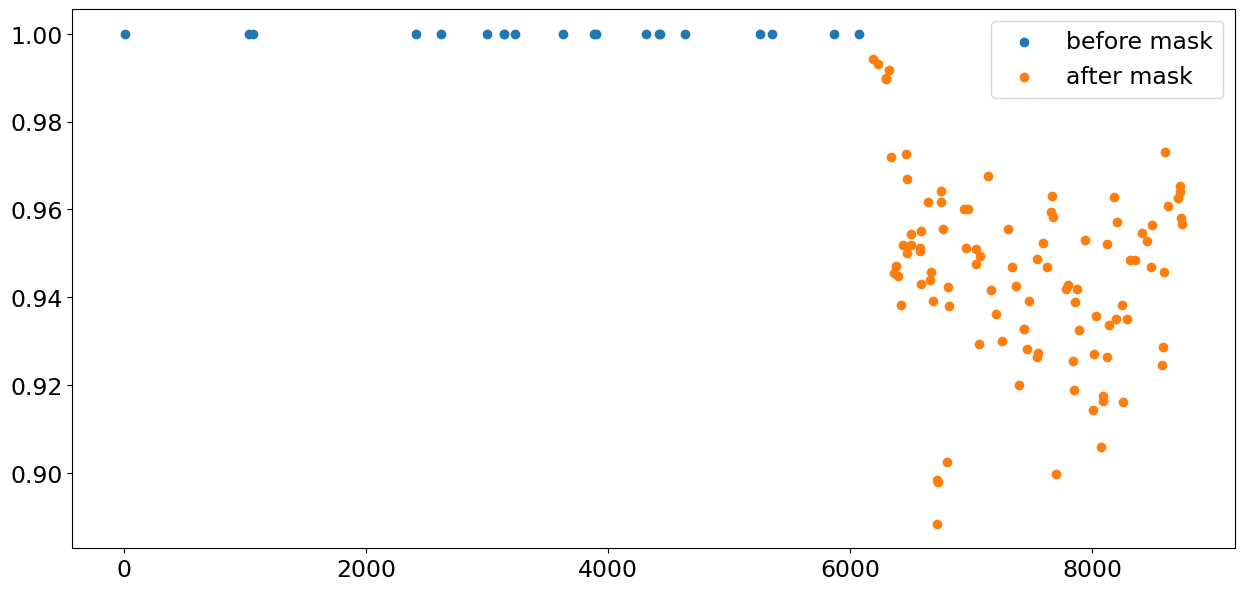

In [48]:
masking_ratio = 0.3
mask_len = int(len(net_consumption_district) * masking_ratio)

idx_pre = np.random.randint(0, len(net_consumption_district) - 48 - mask_len, 20)
idx_post = np.random.randint(len(net_consumption_district) - mask_len + 24, len(net_consumption_district) - 48, 100)
certainty_pre = np.zeros_like(idx_pre, dtype=float)
certainty_post = np.zeros_like(idx_post, dtype=float)

for count, idx in enumerate(idx_pre):
    _, certainty_pre[count] = predict_next_24h_district_masked_with_certainty(net_consumption_district[idx:idx+24], masking_ratio)

for count, idx in enumerate(idx_post):
    _, certainty_post[count] = predict_next_24h_district_masked_with_certainty(net_consumption_district[idx:idx+24], masking_ratio)

plt.figure()
plt.scatter(idx_pre, certainty_pre, label="before mask")
plt.scatter(idx_post, certainty_post, label="after mask")
plt.legend()
plt.show()

We see that before the masked area the prediction is perfect, but after the masked area the prediction certainty is <1, as expected.

The question now is whether we can use this certainty to predict the prediction error.
For this we shall first define it.

## Prediction error

To capture the importance of the first prediction, we will introduce a weighting function.
We want to have high weight for the first prediction and low weight for the last prediction. We heuristically choose an exponent  function for this:

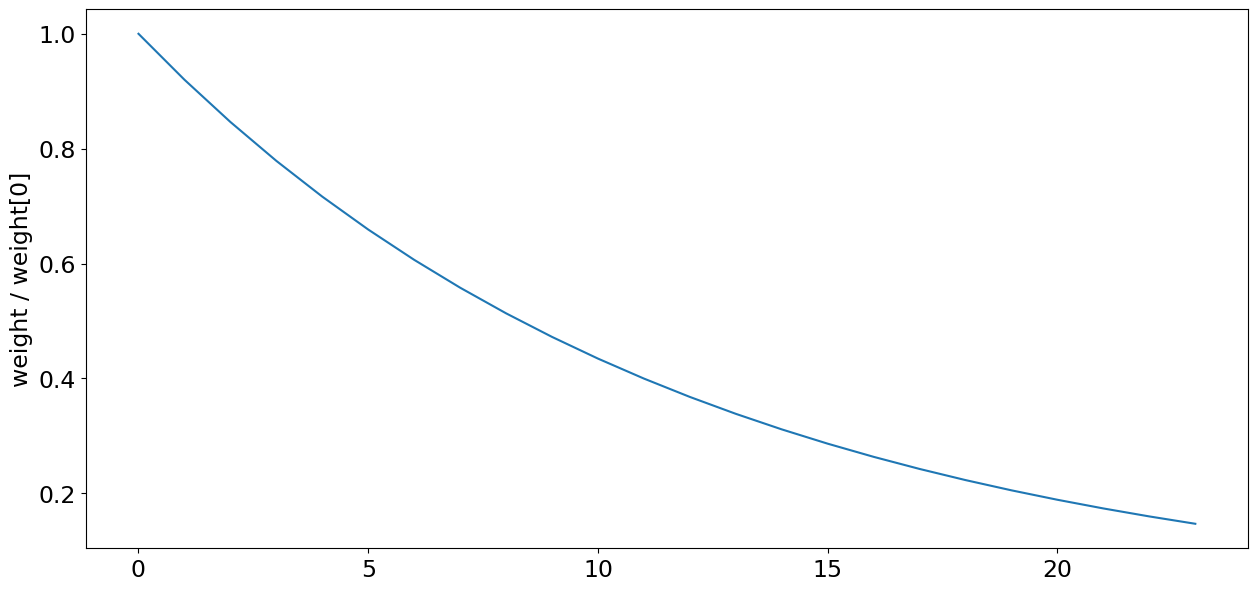

In [49]:
weights_for_loss = np.exp( - np.arange(0, 24) / 12) / sum(np.exp( - np.arange(0, 24) / 12))
plt.figure()
plt.plot(weights_for_loss / weights_for_loss[0])
plt.ylabel("weight / weight[0]")
plt.show()

Now we can define few prediction errors:
- The weighted prediction error, which is the sum of the absolute difference (MAE) between the prediction and the real value, weighted by the weights defined above and normalized by the prediction and ground truth norms.
- RMSE, which is the root mean squared error between the prediction and the real value, with weighting and normalization.
- Dot product, with weighting. We will use $\sqrt(1-z^2)$ to translate the cosine distance to a sine one, so 0 would be perfect prediction and 1 would be the worst prediction.

We also define the uncertainty as 1 - certainty.

### Beware! a long calculation ahead! The results are saved in a csv file, so you can load them from 'data/pre_mask_district.csv', 'data/post_mask_district.csv' and skip this cell.

In [50]:
masking_ratio = 0.3
mask_len = int(len(net_consumption_district) * masking_ratio)

idx_pre = np.random.randint(0, len(net_consumption_district) - 48 - mask_len - 24, 32)
idx_post = np.arange(len(net_consumption_district) - mask_len + 24, len(net_consumption_district) - 48)
certainty_pre = np.zeros_like(idx_pre, dtype=float)
certainty_post = np.zeros_like(idx_post, dtype=float)

weights_for_loss = np.exp( - np.arange(0, 24) / 12) / sum(np.exp( - np.arange(0, 24) / 12))
mae_pre_24 = np.zeros_like(idx_pre, dtype=float)
mae_post_24 = np.zeros_like(idx_post, dtype=float)
rmse_pre_24 = np.zeros_like(idx_pre, dtype=float)
rmse_post_24 = np.zeros_like(idx_post, dtype=float)
mdpe_pre_24 = np.zeros_like(idx_pre, dtype=float)
mdpe_post_24 = np.zeros_like(idx_post, dtype=float)
mae_pre_combined = np.zeros_like(idx_pre, dtype=float)
mae_post_combined = np.zeros_like(idx_post, dtype=float)
rmse_pre_combined = np.zeros_like(idx_pre, dtype=float)
rmse_post_combined = np.zeros_like(idx_post, dtype=float)
mdpe_pre_combined = np.zeros_like(idx_pre, dtype=float)
mdpe_post_combined = np.zeros_like(idx_post, dtype=float)

for count, idx in enumerate(idx_pre):
    prediction, certainty_pre[count] = predict_next_24h_district_masked_with_certainty(net_consumption_district[idx:idx+24], masking_ratio)
    mae_pre_24[count] = sum(abs(prediction - net_consumption_district[idx+24:idx+48]) * weights_for_loss) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_district[idx+24:idx+48] ** 2 * weights_for_loss))
    rmse_pre_24[count] = np.sqrt(sum((prediction - net_consumption_district[idx+24:idx+48]) ** 2 * weights_for_loss)) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_district[idx+24:idx+48] ** 2 * weights_for_loss))
    mdpe_pre_24[count] = sum(prediction * net_consumption_district[idx+24:idx+48] * weights_for_loss) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_district[idx+24:idx+48] ** 2 * weights_for_loss))

    prediction = predict_next_day_district_masked(net_consumption_district[idx:idx+24], masking_ratio)
    mae_pre_combined[count] = sum(abs(prediction - net_consumption_district[idx+24:idx+48]) * weights_for_loss) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_district[idx+24:idx+48] ** 2 * weights_for_loss))
    rmse_pre_combined[count] = np.sqrt(sum((prediction - net_consumption_district[idx+24:idx+48]) ** 2 * weights_for_loss)) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_district[idx+24:idx+48] ** 2 * weights_for_loss))
    mdpe_pre_combined[count] = sum(prediction * net_consumption_district[idx+24:idx+48] * weights_for_loss) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_district[idx+24:idx+48] ** 2 * weights_for_loss))

mdpe_pre_24 = np.sqrt(1 - mdpe_pre_24 ** 2)
mdpe_pre_combined = np.sqrt(1 - mdpe_pre_combined ** 2)
uncertainty_pre = 1 - certainty_pre

for count, idx in enumerate(idx_post):
    prediction, certainty_post[count] = predict_next_24h_district_masked_with_certainty(net_consumption_district[idx:idx+24], masking_ratio)
    mae_post_24[count] = sum(abs(prediction - net_consumption_district[idx+24:idx+48]) * weights_for_loss) / np.sqrt(sum(abs(prediction) * weights_for_loss) + sum(abs(net_consumption_district[idx+24:idx+48]) * weights_for_loss))
    rmse_post_24[count] = np.sqrt(sum((prediction - net_consumption_district[idx+24:idx+48]) ** 2 * weights_for_loss)) / np.sqrt(sum(prediction ** 2 * weights_for_loss) + sum(net_consumption_district[idx+24:idx+48] ** 2 * weights_for_loss))
    mdpe_post_24[count] = sum(prediction * net_consumption_district[idx+24:idx+48] * weights_for_loss) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_district[idx+24:idx+48] ** 2 * weights_for_loss))

    prediction = predict_next_day_district_masked(net_consumption_district[idx:idx+24], masking_ratio)
    mae_post_combined[count] = sum(abs(prediction - net_consumption_district[idx+24:idx+48]) * weights_for_loss) / np.sqrt(sum(abs(prediction) * weights_for_loss) + sum(abs(net_consumption_district[idx+24:idx+48]) * weights_for_loss))
    rmse_post_combined[count] = np.sqrt(sum((prediction - net_consumption_district[idx+24:idx+48]) ** 2 * weights_for_loss)) / np.sqrt(sum(prediction ** 2 * weights_for_loss) + sum(net_consumption_district[idx+24:idx+48] ** 2 * weights_for_loss))
    mdpe_post_combined[count] = sum(prediction * net_consumption_district[idx+24:idx+48] * weights_for_loss) / np.sqrt(sum(prediction ** 2 * weights_for_loss) * sum(net_consumption_district[idx+24:idx+48] ** 2 * weights_for_loss))

mdpe_post_24 = np.sqrt(1 - mdpe_post_24 ** 2)
mdpe_post_combined = np.sqrt(1 - mdpe_post_combined ** 2)
uncertainty_post = 1 - certainty_post

In [51]:
pd.DataFrame({'certainty': certainty_pre, 'uncertainty': uncertainty_pre, 'mae_24': mae_pre_24, 'rmse_24': rmse_pre_24, 'mdpe_24': mdpe_pre_24, 'mae_combined': mae_pre_combined, 'rmse_combined': rmse_pre_combined, 'mdpe_combined': mdpe_pre_combined}).to_csv('data/pre_mask_district.csv', index=False)
pd.DataFrame({'certainty': certainty_post, 'uncertainty': uncertainty_post, 'mae_24': mae_post_24, 'rmse_24': rmse_post_24, 'mdpe_24': mdpe_post_24, 'mae_combined': mae_post_combined, 'rmse_combined': rmse_post_combined, 'mdpe_combined': mdpe_post_combined}).to_csv('data/post_mask_district.csv', index=False)

The cell above calculated all possible loss for both combined and 24h prediction. Now we can plot the losses to see the relation to the certainty.
First, we compare the combined vs. 24 hours only predictions:

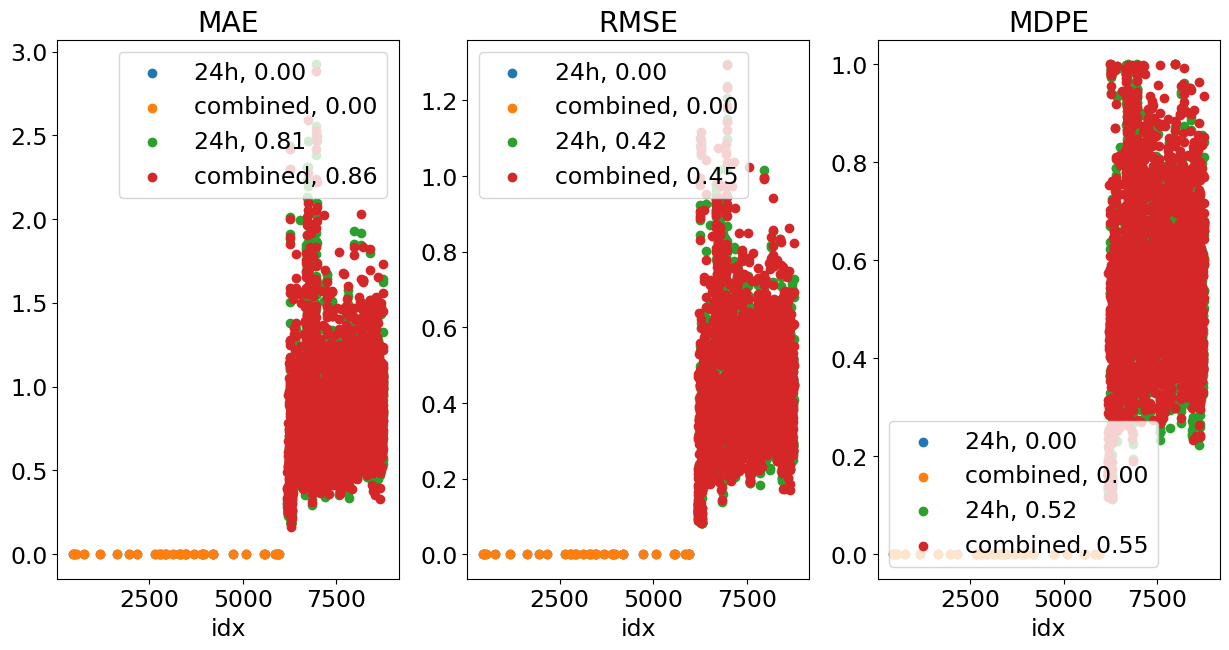

In [52]:
_, axs = plt.subplots(1, 3)

axs[0].scatter(idx_pre, mae_pre_24, label=f"24h, {np.mean(mae_pre_24):.2f}")
axs[0].scatter(idx_pre, mae_pre_combined, label=f"combined, {np.mean(mae_pre_combined):.2f}")
axs[0].scatter(idx_post, mae_post_24, label=f"24h, {np.mean(mae_post_24):.2f}")
axs[0].scatter(idx_post, mae_post_combined, label=f"combined, {np.mean(mae_post_combined):.2f}")
axs[0].set_xlabel("idx")
axs[0].set_title("MAE")
axs[0].legend()

axs[1].scatter(idx_pre, rmse_pre_24, label=f"24h, {np.mean(rmse_pre_24):.2f}")
axs[1].scatter(idx_pre, rmse_pre_combined, label=f"combined, {np.mean(rmse_pre_combined):.2f}")
axs[1].scatter(idx_post, rmse_post_24, label=f"24h, {np.mean(rmse_post_24):.2f}")
axs[1].scatter(idx_post, rmse_post_combined, label=f"combined, {np.mean(rmse_post_combined):.2f}")
axs[1].set_xlabel("idx")
axs[1].set_title("RMSE")
axs[1].legend()

axs[2].scatter(idx_pre, mdpe_pre_24, label=f"24h, {np.mean(mdpe_pre_24):.2f}")
axs[2].scatter(idx_pre, mdpe_pre_combined, label=f"combined, {np.mean(mdpe_pre_combined):.2f}")
axs[2].scatter(idx_post, mdpe_post_24, label=f"24h, {np.mean(mdpe_post_24):.2f}")
axs[2].scatter(idx_post, mdpe_post_combined, label=f"combined, {np.mean(mdpe_post_combined):.2f}")
axs[2].set_xlabel("idx")
axs[2].set_title("MDPE")
axs[2].legend()

plt.show()

Already from these we see that we don't get any gain from the combined prediction, so we dich it and focus on the 24h prediction.
What we will now interest in is the losses vs. the uncertinaty.

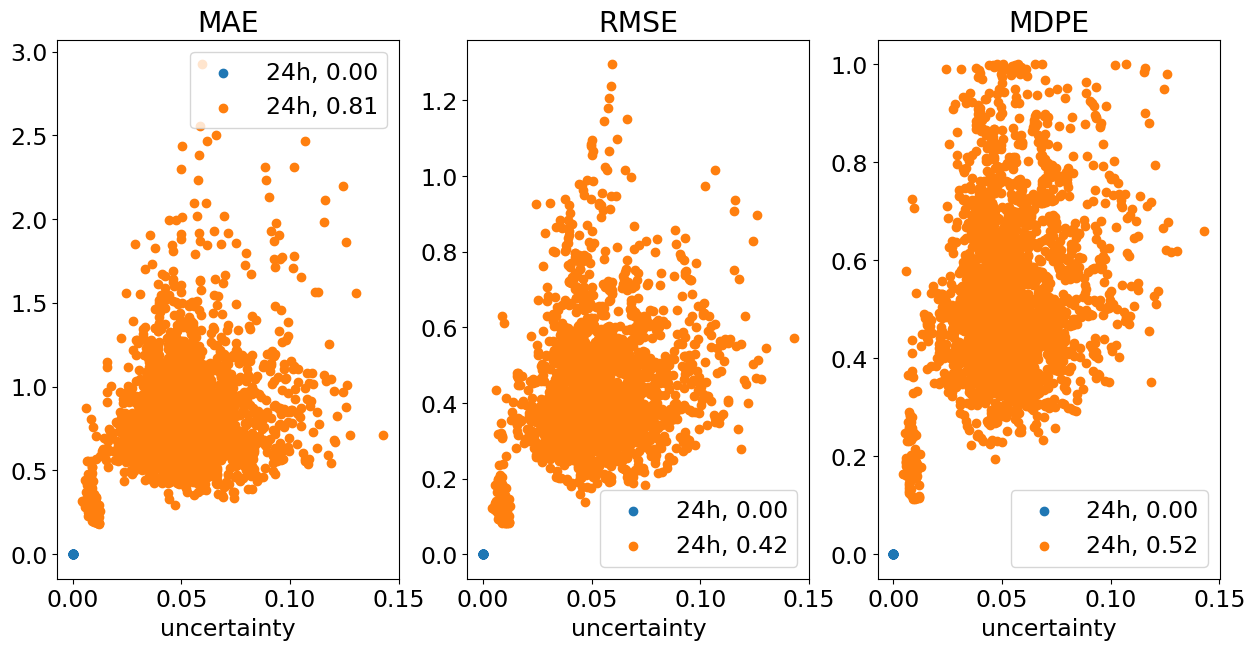

In [53]:
_, axs = plt.subplots(1, 3)

axs[0].scatter(uncertainty_pre, mae_pre_24, label=f"24h, {np.mean(mae_pre_24):.2f}")
axs[0].scatter(uncertainty_post, mae_post_24, label=f"24h, {np.mean(mae_post_24):.2f}")
axs[0].set_xlabel("uncertainty")
axs[0].set_title("MAE")
axs[0].legend()

axs[1].scatter(uncertainty_pre, rmse_pre_24, label=f"24h, {np.mean(rmse_pre_24):.2f}")
axs[1].scatter(uncertainty_post, rmse_post_24, label=f"24h, {np.mean(rmse_post_24):.2f}")
axs[1].set_xlabel("uncertainty")
axs[1].set_title("RMSE")
axs[1].legend()

axs[2].scatter(uncertainty_pre, mdpe_pre_24, label=f"24h, {np.mean(mdpe_pre_24):.2f}")
axs[2].scatter(uncertainty_post, mdpe_post_24, label=f"24h, {np.mean(mdpe_post_24):.2f}")
axs[2].set_xlabel("uncertainty")
axs[2].set_title("MDPE")
axs[2].legend()

plt.show()

We do find some correlation between the losses and the certainty, but it is not very strong. In particular, we never get a loss <10% if the uncertinaty is not 0. Specifically,

In [54]:
print(f"mininal uncertainty for post mask: {np.min(uncertainty_post)}")
print(f"machine epsilon: {np.finfo(float).eps}")
print("")

print(f"mininal MAE for post mask: {np.min(mae_post_24)}")
print(f"mininal RMSE for post mask: {np.min(rmse_post_24)}")
print(f"mininal MDPE for post mask: {np.min(mdpe_post_24)}")
print("")

print(f"maximal uncertainty for pre mask: {np.max(uncertainty_pre)}")


mininal uncertainty for post mask: 0.004357959942541512
machine epsilon: 2.220446049250313e-16

mininal MAE for post mask: 0.18280868617850352
mininal RMSE for post mask: 0.0822459301066306
mininal MDPE for post mask: 0.11227611221701987

maximal uncertainty for pre mask: 2.220446049250313e-16


## Conclusion
At least the mininal uncertinaty for the post mask is quite high, so we can use this as a threshold (say 10*np.finfo(float).eps) to filter out the predictions with low certainty. The rest should be predicted with some conv net, assuming we can get validation loss <10%.

Also remember that we can use the 24hrs prediction, the 4 hours addition is redundant.

In [ ]:
# mae_max_slope = (mae_post_24[uncertainty_post < 0.5] / uncertainty_post[uncertainty_post < 0.5]).max()
# mae_min_slope = (mae_post_24[uncertainty_post < 0.5] / uncertainty_post[uncertainty_post < 0.5]).min()
# rmse_max_slope = (rmse_post_24[uncertainty_post < 0.5] / uncertainty_post[uncertainty_post < 0.5]).max()
# rmse_min_slope = (rmse_post_24[uncertainty_post < 0.5] / uncertainty_post[uncertainty_post < 0.5]).min()
# mdpe_max_slope = (mdpe_post_24[uncertainty_post < 0.5] / uncertainty_post[uncertainty_post < 0.5]).max()
# mdpe_min_slope = (mdpe_post_24[uncertainty_post < 0.5] / uncertainty_post[uncertainty_post < 0.5]).min()
#
# _, axs = plt.subplots(1, 3)
#
# axs[0].scatter(uncertainty_pre, mae_pre_24, label=f"24h, {np.mean(mae_pre_24):.2f}")
# axs[0].scatter(uncertainty_post, mae_post_24, label=f"24h, {np.mean(mae_post_24):.2f}")
# axs[0].set_xlabel("uncertainty")
# axs[0].set_title("MAE")
# axs[0].plot([0, min(mae_max_slope * 0.5, 1) / mae_max_slope], [0, min(mae_max_slope * 0.5, 1)], label=f"max slope, {mae_max_slope:.2f}", linestyle="--")
# axs[0].plot([0, 0.5], [0, mae_min_slope * 0.5], label=f"min slope, {mae_min_slope:.2f}", linestyle="--")
# axs[0].legend()
#
# axs[1].scatter(uncertainty_pre, rmse_pre_24, label=f"24h, {np.mean(rmse_pre_24):.2f}")
# axs[1].scatter(uncertainty_post, rmse_post_24, label=f"24h, {np.mean(rmse_post_24):.2f}")
# axs[1].set_xlabel("uncertainty")
# axs[1].set_title("RMSE")
# axs[1].plot([0, min(rmse_max_slope * 0.5, 1) / rmse_max_slope], [0, min(rmse_max_slope * 0.5, 1)], label=f"max slope, {rmse_max_slope:.2f}", linestyle="--")
# axs[1].plot([0, 0.5], [0, rmse_min_slope * 0.5], label=f"min slope, {rmse_min_slope:.2f}", linestyle="--")
# axs[1].legend()
#
# axs[2].scatter(uncertainty_pre, mdpe_pre_24, label=f"24h, {np.mean(mdpe_pre_24):.2f}")
# axs[2].scatter(uncertainty_post, mdpe_post_24, label=f"24h, {np.mean(mdpe_post_24):.2f}")
# axs[2].set_xlabel("uncertainty")
# axs[2].set_title("MDPE")
# axs[2].plot([0, min(mdpe_max_slope * 0.5, 1) / mdpe_max_slope], [0, min(mdpe_max_slope * 0.5, 1)], label=f"max slope, {mdpe_max_slope:.2f}", linestyle="--")
# axs[2].plot([0, 0.5], [0, mdpe_min_slope * 0.5], label=f"min slope, {mdpe_min_slope:.2f}", linestyle="--")
# axs[2].legend()
#
# plt.show()

In [67]:
# pd.DataFrame(np.array([uncertainty_post, certainty_post, mae_post_24, rmse_post_24, mdpe_post_24, mae_post_combined, rmse_post_combined, mdpe_post_combined]).T, columns=['uncertainty', 'certainty', 'mae_24', 'rmse_24', 'mdpe_24', 'mae_combined', 'rmse_combined', 'mdpe_combined']).to_csv("data/post_mask.csv")